In [2]:
import warnings
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from dotenv import load_dotenv
from omegaconf import OmegaConf
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from transformer_lens import HookedTransformer, HookedTransformerConfig

sys.path.append(f'{os.getcwd()}/../')
from lm_polygraph.stat_calculators import EntropyCalculator
from prompts import w_context_user_prompt, w_context_system_prompt, wo_context_system_prompt
from utils import heatmap_uncertainty
load_dotenv()

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[nltk_data] Downloading package treebank to
[nltk_data]     /home/a.boriskin/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/a.boriskin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nq_dataset = pd.read_csv('../data/adaptive_rag_natural_questions.csv')
wiki_dataset = pd.read_csv('../data/adaptive_rag_2wikimultihopqa.csv'),
hotpot_dataset = pd.read_csv('../data/adaptive_rag_hotpotqa.csv'),
musique_dataset = pd.read_csv('../data/adaptive_rag_musique.csv'),

In [4]:
cfg = OmegaConf.load("../config.yaml")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(cfg.model_id)
model = HookedTransformer.from_pretrained(
    cfg.model_id,
    device=device,
    tokenizer=tokenizer,
)
model.set_use_attn_result(True)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.2-3B-Instruct into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-27): 28 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

In [5]:
nq_dataset

,question_id,question,reference,context,our_answer_wo_context,our_answer_w_context,is_correct_wo_context,is_correct_w_context
0,single_nq_dev_2389,who sings i wont let the sun go down on me,Elton John,"Don't Let the Sun Go Down on Me ""Don't Let the...",Elton John,I do not know.,1,0
1,single_nq_dev_6357,who said if i have seen further it is by stand...,Isaac Newton,calling to his brother through the desolate in...,Isaac Newton,Isaac Newton.,1,1
2,single_nq_dev_6218,who played joel in the last of us,Troy Edward Baker,"Troy Baker Troy Edward Baker (born April 1, 19...",Troy Baker,Troy Baker,1,1
3,single_nq_dev_5033,how many episodes are there of seven seconds,10,teenager from Jersey City—with his car. Jablon...,"I couldn't find any information on ""Seven Seco...",I do not know.,0,0
4,single_nq_dev_2438,actress who plays hillary on the young and the...,Marie - Charms Mishael Morgan,Mishael Morgan Marie-Charms Mishael Morgan (bo...,Melody Thomas Scott,Mishael Morgan.,0,1
...,...,...,...,...,...,...,...,...
495,single_nq_dev_2293,what is a set of kettledrums in an orchestra c...,Timpani,Timpani Timpani (; ) or kettledrums (also info...,Timpani,A set of kettledrums in an orchestra is called...,1,1
496,single_nq_dev_1284,who wrote an essay on the principle of population,Thomas Robert Malthus,An Essay on the Principle of Population The bo...,Thomas Malthus,"Who wrote ""An Essay on the Principle of Popula...",1,1
497,single_nq_dev_5685,actor who sang i talk to the trees in the movi...,Pardner,a partner. Ben will share the spoils of prospe...,Cloris Leachman,Lee Marvin.,0,0
498,single_nq_dev_3239,this term means a state has supreme and absolu...,Sovereignty,regardless of the intentions. Sovereignty Sove...,Sovereignty,1. What is sovereignty?\n Full right and power...,1,0


In [15]:
def logits_dataset(dataset, model, tokenizer):
    features_list = []
    labels = []
    for _, row in tqdm(dataset.iterrows(), total=len(dataset)):
        
        text = tokenizer.apply_chat_template([
                {"role": "user", "content": f"question: {row['question']}\nanswer: {row['our_answer_wo_context']}"}, 
            ], tokenize=False, add_generation_prompt=True)
            
        tokens = model.to_tokens(text, prepend_bos=False).to(device)
        with torch.no_grad():
            # logits = model.run_with_hooks(
            #     tokens,
            #     return_type="logits",
            #     fwd_hooks=[(f"blocks.{i}.hook_resid_post", store_activations(activation_store))
            #                for i in range(model.cfg.n_layers)]
            # ) # (1, seq_len, vocab_size)
            logits = model(tokens) # (1, seq_len, vocab_size)
    
        logits = logits.detach().cpu()
        final_logits = logits[:, -1, :].squeeze(dim=0) # (vocab_size)
        features_list.append(final_logits)
        labels.append(int(row['is_correct_wo_context']))
        
    X = np.stack(features_list) 
    y = np.array(labels)
    return X, y

In [19]:
X, y = logits_dataset(nq_dataset, model, tokenizer)

100%|██████████| 500/500 [00:37<00:00, 13.38it/s]


In [22]:
print(X.shape)
print(y.shape)

(500, 128256)
(500,)


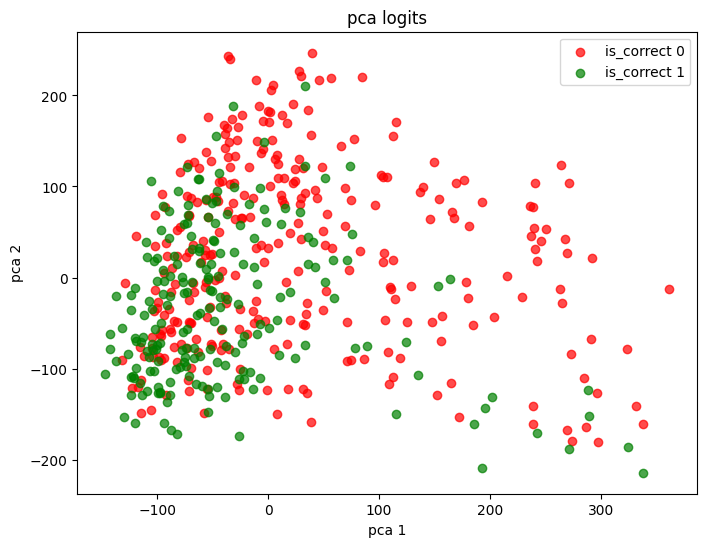

In [30]:
colors = {0: 'red', 1: 'green'}

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("pca 1")
plt.ylabel("pca 2")
plt.title("pca logits")
plt.legend()
plt.show()

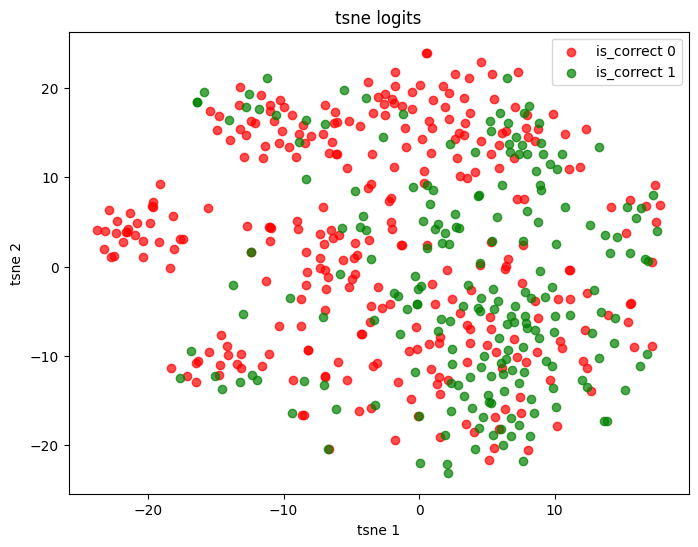

In [32]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("tsne logits")
plt.legend()
plt.show()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [35]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        59
           1       0.61      0.54      0.57        41

    accuracy                           0.67       100
   macro avg       0.66      0.65      0.65       100
weighted avg       0.67      0.67      0.67       100

